In [2]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
import statistics
import _pickle as pickle
import json
import csv
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

[nltk_data] Downloading package stopwords to C:\Users\Andrew
[nltk_data]     Sai\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Andrew
[nltk_data]     Sai\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
aita_df = pd.read_csv("reddit_aitaR.csv")
print("The size of the dataframe is {}.".format(aita_df.shape))
aita_df.head()

The size of the dataframe is (943, 16).


,Unnamed: 0,title,author,likes,comments,story,user_comment1,user_comment2,user_comment3,user_comment4,user_comment5,user_comment6,user_comment7,user_comment8,user_comment9,user_comment10
0,0,"UPDATE, AITA for despising my mentally handica...",Renegadesrule33,71.4k,2019,"I'm back like I said I would be,. My original ...","I'm back like I said I would be,. My original ...",Wow. OP's grandfather is a saint.\r\n,"Too right my guy, the sad thing is is that he ...",Reminds me of my wife's parents in a way. She...,This happened to an ex of mine. Her step fathe...,"That's a good story, always nice to hear a sto...","wait, you adopted your ex?\r\n","His parents did, while they were together in o...","Yes this, i was 16 at the time she was 15. Unl...",She's not like family. She's your sister. I'm ...
1,1,UPDATE: AITA for wanting to go to the funeral ...,sgdneyrother,63.8k,2,I want to sincerely thank everyone who comment...,I want to sincerely thank everyone who comment...,We've chosen to lock this update due to the hi...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,META: Too many AITA commenters advocate too qu...,Cosmohumanist,52.7k,1646,I’ve become frustrated with how quick a lot of...,I’ve become frustrated with how quick a lot of...,Sometimes I'm surprised by how quickly people ...,Totally agree. And I absolutely appreciate the...,I think that it's only because the most logica...,Leaving a truly bad situation is necessary and...,\r\nMy issue is when we equate difficult with ...,I think a huge part of the problem is that if ...,The biggest lesson about love I’ve learned the...,"When people come to r/relationship_advice, the...",Thanks for taking that time for your reply.\r\...
3,3,AITA for telling my extended family how many m...,Thunderbear998,48.1k,5401,We had a family dinner this evening. My family...,We had a family dinner this evening. My family...,I think everything that needs to be said on ei...,ESH One person making personal attacks doesn’t...,"Yeah ESH seems right, not cool of her to be go...",I’ll never understand why people with bigger s...,It's possible that they don't think people wil...,"Some kind of ""too big to fail""? Their skeleton...",That’s a decent point that I hadn’t considered...,Bullies tend to think they are invulnerable ti...,"not necessarily the better person - just a ""co..."
4,4,AITA for despising my mentally handicap sister?,Renegadesrule33,46.2k,2764,The title makes me sound horrible but hear me ...,The title makes me sound horrible but hear me ...,If you want your comment to count toward judgm...,NTA. These are perfectly legitimate and unders...,"Hey, autistic guy here, can confirm that OP is...",Thank you for sharing and being so open! It so...,No problem at all! And i can kinda relate to h...,Hi! Former genetic engineering major here! Swi...,But you can cure autism by just not getting va...,LMAO I’m gonna be loving it if the “cure” is a...,Given what the commented said further up I can...


# Missing Data

The missing data isn't because we have incorrectly scrapped the data from the subreddit but rather it is when a moderator(mod) choses to lock the thread early. When a mod does this, it stops all new comments from being uploaded. So the missing data is from user comments where it was locked after the 2nd or 3rd user comment thus the missing data. Therefore we will just fill these missing data with 'No comments allowed'.

In [4]:
aita_df.isnull().sum()

Unnamed: 0        0
title             0
author            0
likes             0
comments          0
story             0
user_comment1     0
user_comment2     0
user_comment3     2
user_comment4     2
user_comment5     2
user_comment6     2
user_comment7     2
user_comment8     2
user_comment9     3
user_comment10    3
dtype: int64

In [5]:
aita_df[aita_df.isnull().any(axis=1)]

,Unnamed: 0,title,author,likes,comments,story,user_comment1,user_comment2,user_comment3,user_comment4,user_comment5,user_comment6,user_comment7,user_comment8,user_comment9,user_comment10
1,1,UPDATE: AITA for wanting to go to the funeral ...,sgdneyrother,63.8k,2,I want to sincerely thank everyone who comment...,I want to sincerely thank everyone who comment...,We've chosen to lock this update due to the hi...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
501,501,"Update! AITA for calling my brothers gf ""miss ...",Salt_Slip,8282,18,I just want to start by saying holy hell. I di...,I just want to start by saying holy hell. I di...,Getting way too close to reading like you're l...,[removed]\r\n,[removed]\r\n,[removed]\r\n,[removed]\r\n,[removed]\r\n,[removed]\r\n,NaN,NaN
671,671,UPDATE! AITA for not telling my boyfriend I kn...,secretivegfandsis,5603,2,Hey again guys! Thank you all so much for the ...,Hey again guys! Thank you all so much for the ...,Link to original. Because this involves violen...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
aita_df.fillna("No comments allowed", inplace=True)

# Word Count - Feature

A key feature that we can extract from the text is the word count. The word count will include stopwords but it will give us insights like how much the average user types for their title, story and comments. And we can see if these word counts are affected by seasonality or certain themes later on.

In [7]:
aita_df['story_wordcount'] = aita_df['story'].apply(lambda x: len(x.split()))
aita_df['title_wordcount'] = aita_df['title'].apply(lambda x: len(x.split()))

In [8]:
user_comment = []
for num in range(1,11):
    user_comment.append('user_comment{}_wordcount'.format(num))
counter = 0
for col in range(1, 11):
    aita_df['{}'.format(user_comment[counter])] = aita_df['user_comment{}'.format(col)].apply(lambda x: len(x.split()))
    counter += 1

# Upvotes / likes

The likes are done for example like 31.5k or 12k. We will need to replace these strings into int so the model can understand that it is ordinal numerical data. Thus we will replace '.' with '' and k with 00. Then change the variable to an integer.

In [9]:
aita_df['likes'] = aita_df.likes.apply(lambda x: x.replace('.', ''))
aita_df['likes'] = aita_df.likes.apply(lambda x: x.replace('k', '00'))
aita_df['likes'] = aita_df['likes'].astype(int)

# Age - feature

Another key insight we can obtain from some of the stories is that the user sometimes place age. By using the age we can get a general understanding of the common age bracket. For now we will just grab the first age of male and female in the stories. Another option is using the median of all ages located. 

In [10]:
male_age_re = re.compile('\d\d[Mm]')
female_age_re = re.compile('\d\dF|m')
male_age = re.findall(male_age_re, aita_df['story'][3])
female_age = re.findall(female_age_re, aita_df['story'][3])

In [11]:
male_age_re = re.compile('\d\d[Mm]')
female_age_re = re.compile('\d\d[Ff]')
aita_df['male_age'] = aita_df['story'].apply(lambda x: re.findall(male_age_re, x))
aita_df['male_age'] = aita_df['male_age'].apply(lambda x: 0 if len(x)== 0 else x[0])
aita_df['female_age'] = aita_df['story'].apply(lambda x: re.findall(female_age_re, x))
aita_df['female_age'] = aita_df['female_age'].apply(lambda x: 0 if len(x)== 0 else x[0])
aita_df['male_age'] = aita_df['male_age'].apply(lambda x: re.sub(r'M|m', r'', str(x)))
aita_df['male_age'] = aita_df['male_age'].astype(np.int64)
aita_df['female_age'] = aita_df['female_age'].apply(lambda x: re.sub(r'F|f', r'', str(x)))
aita_df['female_age'] = aita_df['female_age'].astype(np.int64)

# Word cleaning

We will begin cleaning the text so we can prepare it for further analysis and modelling. We will be removing all digits, making all text lowercase and getting rid of punctuation and stopwords. Stopwords are words like 'all', 'same' 'if' which are words search engine use to ignore. Lemmatization is the process of reducing inflectional forms and derive forms of words related to a comman base. E.g. different -> differ, boy's -> boy.

In [12]:
def word_digit_clean(word):
    word = ''.join([i for i in word if not i.isdigit()])    
    html_tags = re.compile('<.*?>')
    return word

In [13]:
aita_df['story_clean'] = aita_df['story'].apply(lambda x: word_digit_clean(x))
aita_df['title_clean'] = aita_df['title'].apply(lambda x: word_digit_clean(x))
user_comment = []
for num in range(1,11):
    user_comment.append('user_comment{}_clean'.format(num))
counter = 0
for col in range(1, 11):
    aita_df['{}'.format(user_comment[counter])] = aita_df['user_comment{}'.format(col)].apply(lambda x: word_digit_clean(x))
    counter += 1

In [14]:
tokenizer = RegexpTokenizer(r'\w+')
aita_df['story_clean'] = aita_df['story_clean'].apply(lambda x: tokenizer.tokenize(x.lower()))
aita_df['title_clean'] = aita_df['title_clean'].apply(lambda x: tokenizer.tokenize(x.lower()))
for col in range(1, 11):
    aita_df['user_comment{}_clean'.format(col)] = aita_df['user_comment{}_clean'.format(col)].apply(lambda x:tokenizer.tokenize(x.lower()))
    counter += 1

In [15]:
def remove_stopwords(text):
    words = [word for word in text if word not in stopwords.words('english')]
    return words

In [16]:
aita_df['story_clean'] = aita_df['story_clean'].apply(lambda x: remove_stopwords(x))
aita_df['title_clean'] = aita_df['title_clean'].apply(lambda x: remove_stopwords(x))
for col in range(1, 11):
    aita_df['user_comment{}_clean'.format(col)] = aita_df['user_comment{}_clean'.format(col)].apply(lambda x: remove_stopwords(x))
    counter += 1

In [17]:
lemmatizer = WordNetLemmatizer()
def word_lemmatizer(text):
    lem_text = " ".join([lemmatizer.lemmatize(i) for i in text])
    return lem_text

In [18]:
aita_df['story_clean'] = aita_df['story_clean'].apply(lambda x: word_lemmatizer(x))
aita_df['title_clean'] = aita_df['title_clean'].apply(lambda x: word_lemmatizer(x))
for col in range(1, 11):
    aita_df['user_comment{}_clean'.format(col)] = aita_df['user_comment{}_clean'.format(col)].apply(lambda x: word_lemmatizer(x))
    counter += 1

# Word value counts 

We will used the clean text from the columns, title, story, usercomments1-10 and determine its frequency of all the words. The goal of this is to create visualisation of what are the common words used for these features. We will visualise it in two ways through a wordcloud and a bar graph. Wordclouds are great for everyday viewers to get some insights from the visualisation however flaws such as longer words appear bigger creates it harder to truly understand the data. Thus the bar graph will implemented to supplement the word cloud. 

Interactive dashboards will also be planned.

In [19]:
story_wordlist = aita_df['story_clean'].str.split(expand = True).stack().value_counts().astype(int)
title_wordlist = aita_df['title_clean'].str.split(expand = True).stack().value_counts().astype(int)
user_comment1_wordlist = aita_df['user_comment1_clean'].str.split(expand = True).stack().value_counts().astype(int)
user_comment2_wordlist = aita_df['user_comment2_clean'].str.split(expand = True).stack().value_counts().astype(int)
user_comment3_wordlist = aita_df['user_comment3_clean'].str.split(expand = True).stack().value_counts().astype(int)
user_comment4_wordlist = aita_df['user_comment4_clean'].str.split(expand = True).stack().value_counts().astype(int)
user_comment5_wordlist = aita_df['user_comment5_clean'].str.split(expand = True).stack().value_counts().astype(int)
user_comment6_wordlist = aita_df['user_comment6_clean'].str.split(expand = True).stack().value_counts().astype(int)
user_comment7_wordlist = aita_df['user_comment7_clean'].str.split(expand = True).stack().value_counts().astype(int)
user_comment8_wordlist = aita_df['user_comment8_clean'].str.split(expand = True).stack().value_counts().astype(int)
user_comment9_wordlist = aita_df['user_comment9_clean'].str.split(expand = True).stack().value_counts().astype(int)
user_comment10_wordlist = aita_df['user_comment10_clean'].str.split(expand = True).stack().value_counts().astype(int)

In [20]:
story_wordlist_dict = dict(story_wordlist)
title_wordlist_dict = dict(title_wordlist)
user_comment1_dict = dict(user_comment1_wordlist)
user_comment2_dict = dict(user_comment2_wordlist)
user_comment3_dict = dict(user_comment3_wordlist)
user_comment4_dict = dict(user_comment4_wordlist)
user_comment5_dict = dict(user_comment5_wordlist)
user_comment6_dict = dict(user_comment6_wordlist)
user_comment7_dict = dict(user_comment7_wordlist)
user_comment8_dict = dict(user_comment8_wordlist)
user_comment9_dict = dict(user_comment9_wordlist)
user_comment10_dict = dict(user_comment10_wordlist)

In [21]:
print(len(story_wordlist_dict))
print(len(title_wordlist_dict))
print(len(user_comment1_dict))
print(len(user_comment2_dict))
print(len(user_comment3_dict))
print(len(user_comment4_dict))
print(len(user_comment5_dict))
print(len(user_comment6_dict))
print(len(user_comment7_dict))
print(len(user_comment8_dict))
print(len(user_comment9_dict))
print(len(user_comment10_dict))

11498
1958
11498
1905
4152
4272
4320
4229
4312
4361
4286
4430


In [22]:
story, story_frequency = list(story_wordlist_dict.keys())[:1000], list(story_wordlist_dict.values())[:1000]
title, title_frequency = list(title_wordlist_dict.keys())[:1000], list(title_wordlist_dict.values())[:1000]
uc1, uc1_frequency = list(user_comment1_dict.keys())[:1000], list(user_comment1_dict.values())[:1000]
uc2, uc2_frequency = list(user_comment2_dict.keys())[:1000], list(user_comment2_dict.values())[:1000]
uc3, uc3_frequency = list(user_comment3_dict.keys())[:1000], list(user_comment3_dict.values())[:1000]
uc4, uc4_frequency = list(user_comment4_dict.keys())[:1000], list(user_comment4_dict.values())[:1000]
uc5, uc5_frequency = list(user_comment5_dict.keys())[:1000], list(user_comment5_dict.values())[:1000]
uc6, uc6_frequency = list(user_comment6_dict.keys())[:1000], list(user_comment6_dict.values())[:1000]
uc7, uc7_frequency = list(user_comment7_dict.keys())[:1000], list(user_comment7_dict.values())[:1000]
uc8, uc8_frequency = list(user_comment8_dict.keys())[:1000], list(user_comment8_dict.values())[:1000]
uc9, uc9_frequency = list(user_comment9_dict.keys())[:1000], list(user_comment9_dict.values())[:1000]
uc10, uc10_frequency = list(user_comment10_dict.keys())[:1000], list(user_comment10_dict.values())[:1000]

In [40]:
word_df = word_df.assign(story=story, story_frequency=story_frequency, title=title, title_frequency=title_frequency,
                        uc1=uc1, uc1_frequency=uc1_frequency, uc2=uc2, uc2_frequency=uc2_frequency, 
                        uc3=uc3, uc3_frequency=uc3_frequency, uc4=uc4, uc4_frequency=uc4_frequency, 
                        uc5=uc5, uc5_frequency=uc5_frequency, uc6=uc6, uc6_frequency=uc6_frequency, 
                        uc7=uc7, uc7_frequency=uc7_frequency, uc8=uc8, uc8_frequency=uc8_frequency, 
                        uc9=uc9, uc9_frequency=uc9_frequency, uc10=uc10, uc10_frequency=uc10_frequency)

In [42]:
word_df.to_csv('word_frequncy.csv')

In [69]:
story_wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate_from_frequencies(story_wordlist_dict)
title_wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate_from_frequencies(title_wordlist_dict)
uc1_wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate_from_frequencies(user_comment1_dict)
uc2_wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate_from_frequencies(user_comment2_dict)
uc3_wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate_from_frequencies(user_comment3_dict)
uc4_wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate_from_frequencies(user_comment4_dict)
uc5_wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate_from_frequencies(user_comment5_dict)
uc6_wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate_from_frequencies(user_comment6_dict)
uc7_wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate_from_frequencies(user_comment7_dict)
uc8_wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate_from_frequencies(user_comment8_dict)
uc9_wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate_from_frequencies(user_comment9_dict)
uc10_wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate_from_frequencies(user_comment10_dict)

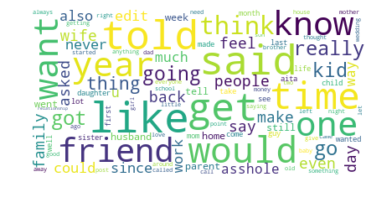

In [65]:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [72]:
story_wordcloud.to_file("story_wordcloud.png")
title_wordcloud.to_file("title_wordcloud.png")
uc1_wordcloud.to_file("uc1_wordcloud.png")
uc2_wordcloud.to_file("uc2_wordcloud.png")
uc3_wordcloud.to_file("uc3_wordcloud.png")
uc4_wordcloud.to_file("uc4_wordcloud.png")
uc5_wordcloud.to_file("uc5_wordcloud.png")
uc6_wordcloud.to_file("uc6_wordcloud.png")
uc7_wordcloud.to_file("uc7_wordcloud.png")
uc8_wordcloud.to_file("uc8_wordcloud.png")
uc9_wordcloud.to_file("uc9_wordcloud.png")
uc10_wordcloud.to_file("uc10_wordcloud.png")

In [80]:
for col in range(1,11):
    print('uc{}_sns_plot = sns.barplot(x="frequency", y = "word", data=word_df["uc{}", "uc{}_frequency"])'.format(col, col, col))

uc1_sns_plot = sns.barplot(x="frequency", y = "word", data=word_df["uc1", "uc1_frequency"])
uc2_sns_plot = sns.barplot(x="frequency", y = "word", data=word_df["uc2", "uc2_frequency"])
uc3_sns_plot = sns.barplot(x="frequency", y = "word", data=word_df["uc3", "uc3_frequency"])
uc4_sns_plot = sns.barplot(x="frequency", y = "word", data=word_df["uc4", "uc4_frequency"])
uc5_sns_plot = sns.barplot(x="frequency", y = "word", data=word_df["uc5", "uc5_frequency"])
uc6_sns_plot = sns.barplot(x="frequency", y = "word", data=word_df["uc6", "uc6_frequency"])
uc7_sns_plot = sns.barplot(x="frequency", y = "word", data=word_df["uc7", "uc7_frequency"])
uc8_sns_plot = sns.barplot(x="frequency", y = "word", data=word_df["uc8", "uc8_frequency"])
uc9_sns_plot = sns.barplot(x="frequency", y = "word", data=word_df["uc9", "uc9_frequency"])
uc10_sns_plot = sns.barplot(x="frequency", y = "word", data=word_df["uc10", "uc10_frequency"])


In [85]:
uc1_sns_plot = sns.barplot(x="frequency", y = "word", data=word_df[["uc1", "uc1_frequency"]])


ValueError: Could not interpret input 'frequency'

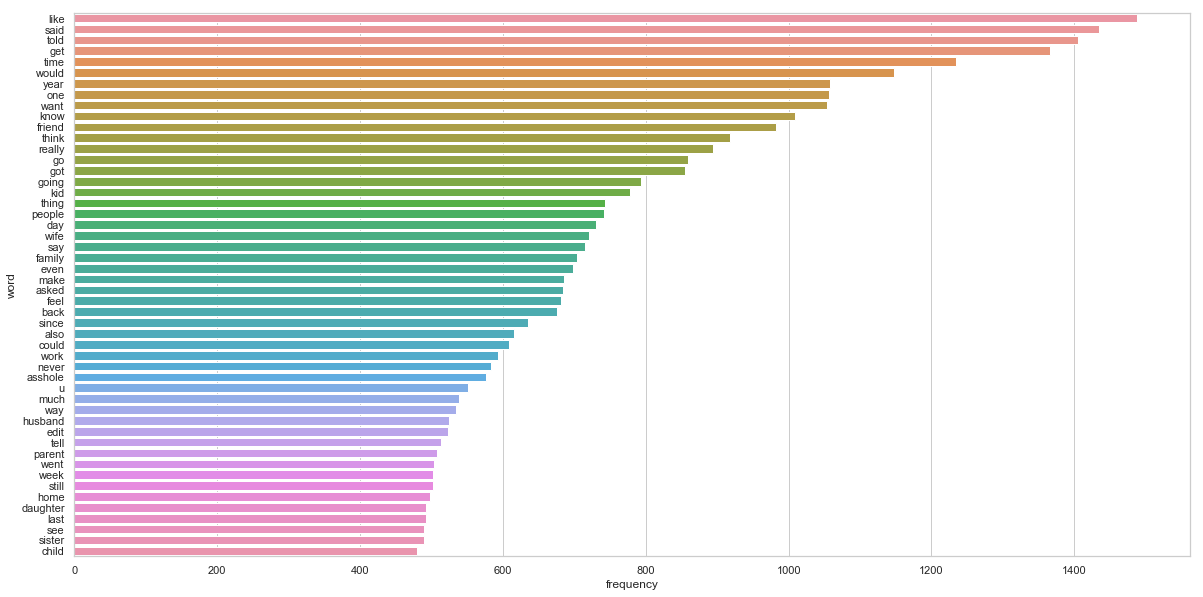

In [76]:
sns.set(style="whitegrid")
plt.figure(figsize=(20, 10))
sns_plot = sns.barplot(x="frequency", y="word", data=word_df[:50])

In [79]:
sns_plot.figure.savefig("wordbar.png")